In [1]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## <font size="7">Überschrift</font><a class="anchor" id="4-03a-ueberschrift"></a>

<font size="5">
Das Notebook fasst jeweils die Entwicklung eines Netzes. An dieser Stelle wird der dieser Entwicklung zugrunde liegende Ansatz sowie das Modell beschrieben.
</font>


### <font size="5">Modell und Parameter</font>

<font size="5">
In dieser Stelle wird das zu erstellende Modell definiert. Die Methode model_creation() erstellt das Netz, welches dann im weiteren Verlauf trainiert wird. Hier werden außerdem die übrigen Hyperparameter festgelegt.
</font>


In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    regularizer = l2(0.0001)
    
    model.add(Dense(units=64, kernel_regularizer=regularizer, activation="relu"))
    model.add(LSTM(units=128, kernel_regularizer=regularizer, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

<font size="5">
In dieser Zelle werden die Daten geladen und in Zeitfenster für LSTM umgewandelt. Da es sich hier stets um das gleiche Vorgehen handelt, welches nur durch den Paramter window_size gesteuert wird, ist diese Zelle in den übrigen Notebooks gegebenenfalls ausgeblendet.
</font>


In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

<font size="5">
In dieser Zelle wird das Training mit fünffacher Kreuzvalidierung durchgeführt. Da es sich auch hier um immer den gleichen Code handelt, wird diese Zelle gegebenenfalls ausgeblendet.
</font>


In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

<font size="5">
Hier werden die Metriken für jede Kreuzvalidierung sowie der Durchschnitt ausgegeben. Anhand dieser Metriken lässt sich das in der jeweiligen Kreuzvalidierung erstellte Modell bewerten. Außerdem wird hier die Lernkurve der Verlustfunktion gezeichnet. Die rote und blaue Linie repräsentiert die Durchschnitte, die gestrichelten Linien jeweils die Verlustfunktion der einzelnen Kreuzvalidierungen.
<br><br>
Die Verlustfunktion wird zu besseren Interpretierbarkeit vom skalierten Wertebereich in den tatsächlichen Werteberiech umgewandelt.
</font>


         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.05            1.63               1.90
2             2.06            1.35               1.84
3             2.12            1.47               1.81
4             2.01            1.50               1.93
5             1.98            1.49               1.81
Average       2.04            1.49               1.86





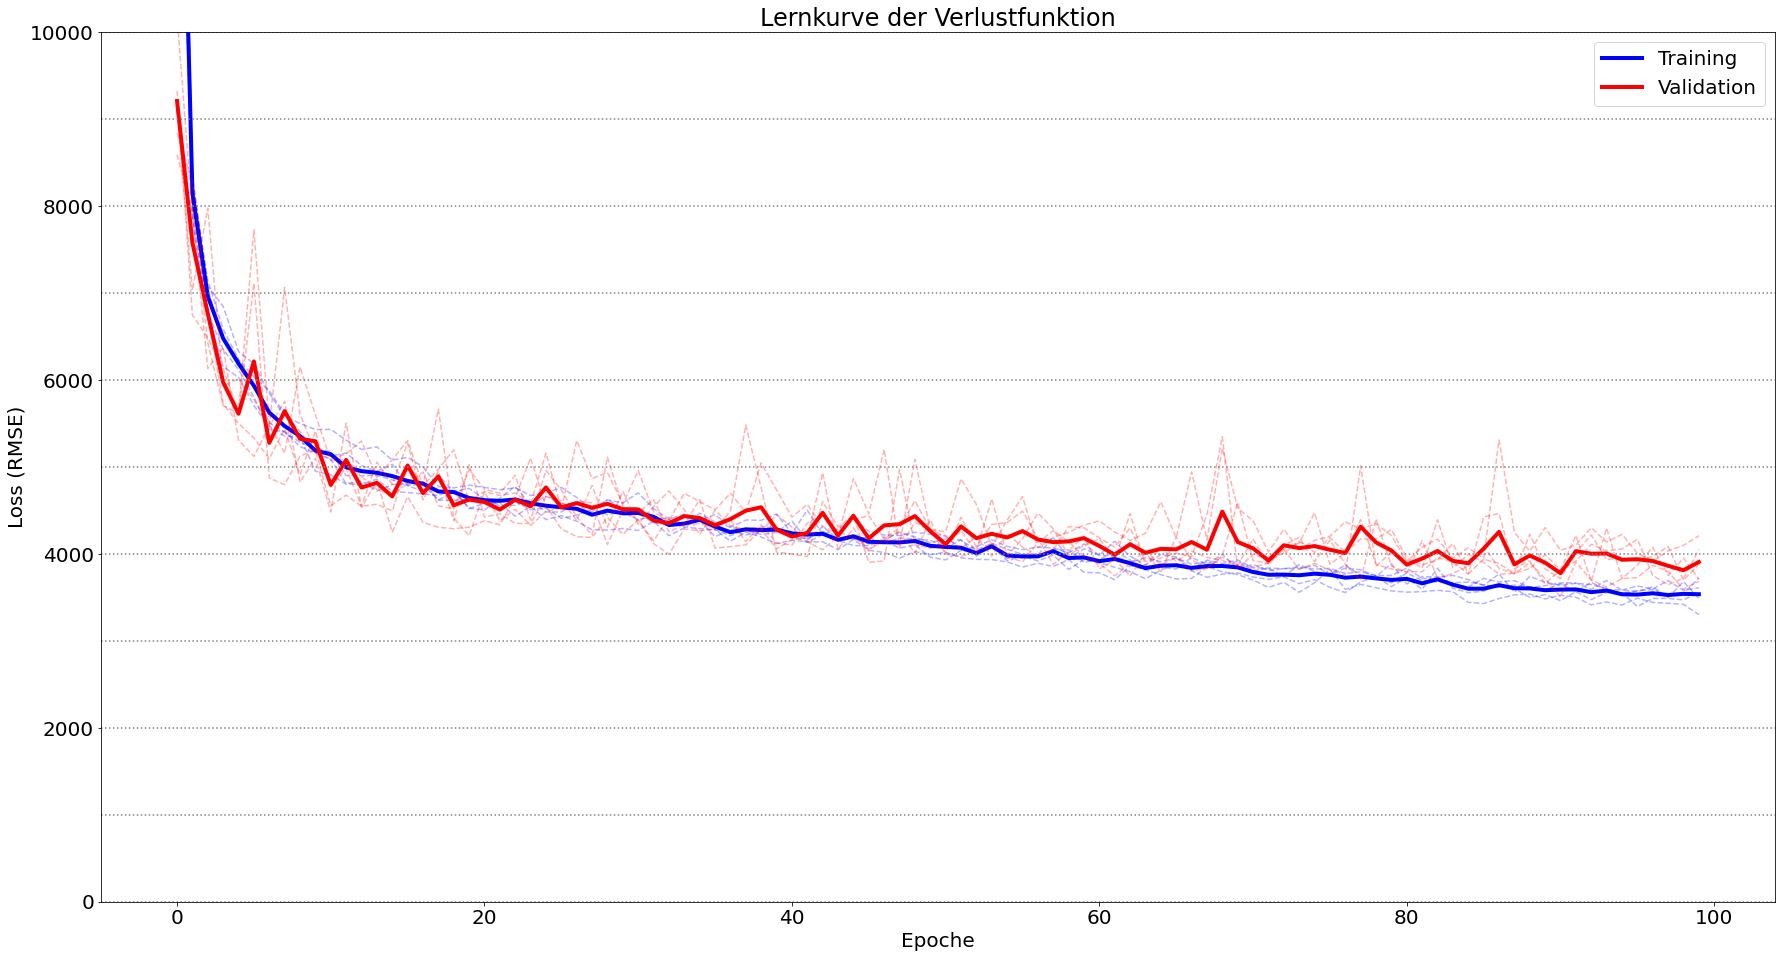

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 10000)

<font size="5">
An dieser Stelle steht jeweils die Auswertung des Modells beziehungsweise des Trainings und Bewertung des Ansatzes. Hier werden sowohl die Metriken aus den Kreuzvalidierungen und  Lernkurve ausgewertet. Zusätzlich wird weiter unten nochmal ein Modell mit allen Trainingsdate erstellt und mit den Testdaten getestet. Anhand dieses Modells findet die abschließende Bewertung des Ansatzes statt.
</font>


### <font size="5">Test</font>

<font size="5">
In dieser Zelle wird der finale Test des Modells durchgeführt. Hierfür wird, wie bereits beschrieben, ein Modell mit allen Trainingsdaten erstellt.
</font>


In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 7ms/step - loss: 0.1061
Epoch 2/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0577
Epoch 3/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0514
Epoch 4/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0471
Epoch 5/100
273/273 [==============================] - 2s 8ms/step - loss: 0.0455
Epoch 6/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0443
Epoch 7/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0416
Epoch 8/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0403
Epoch 9/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0396
Epoch 10/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0383
Epoch 11/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0382
Epoch 12/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0371
Epoch 13/100


<font size="5">
In dieser Zelle wird das finale Modell getestet und bewertet.
</font>


       Testdaten Trainingsdaten
R2          0.97           0.99
MAE       3226.0         2213.0
MSE   19654252.0     10226540.0
RMSE      4433.0         3198.0
                               
MAPE      1.94 %         1.37 %


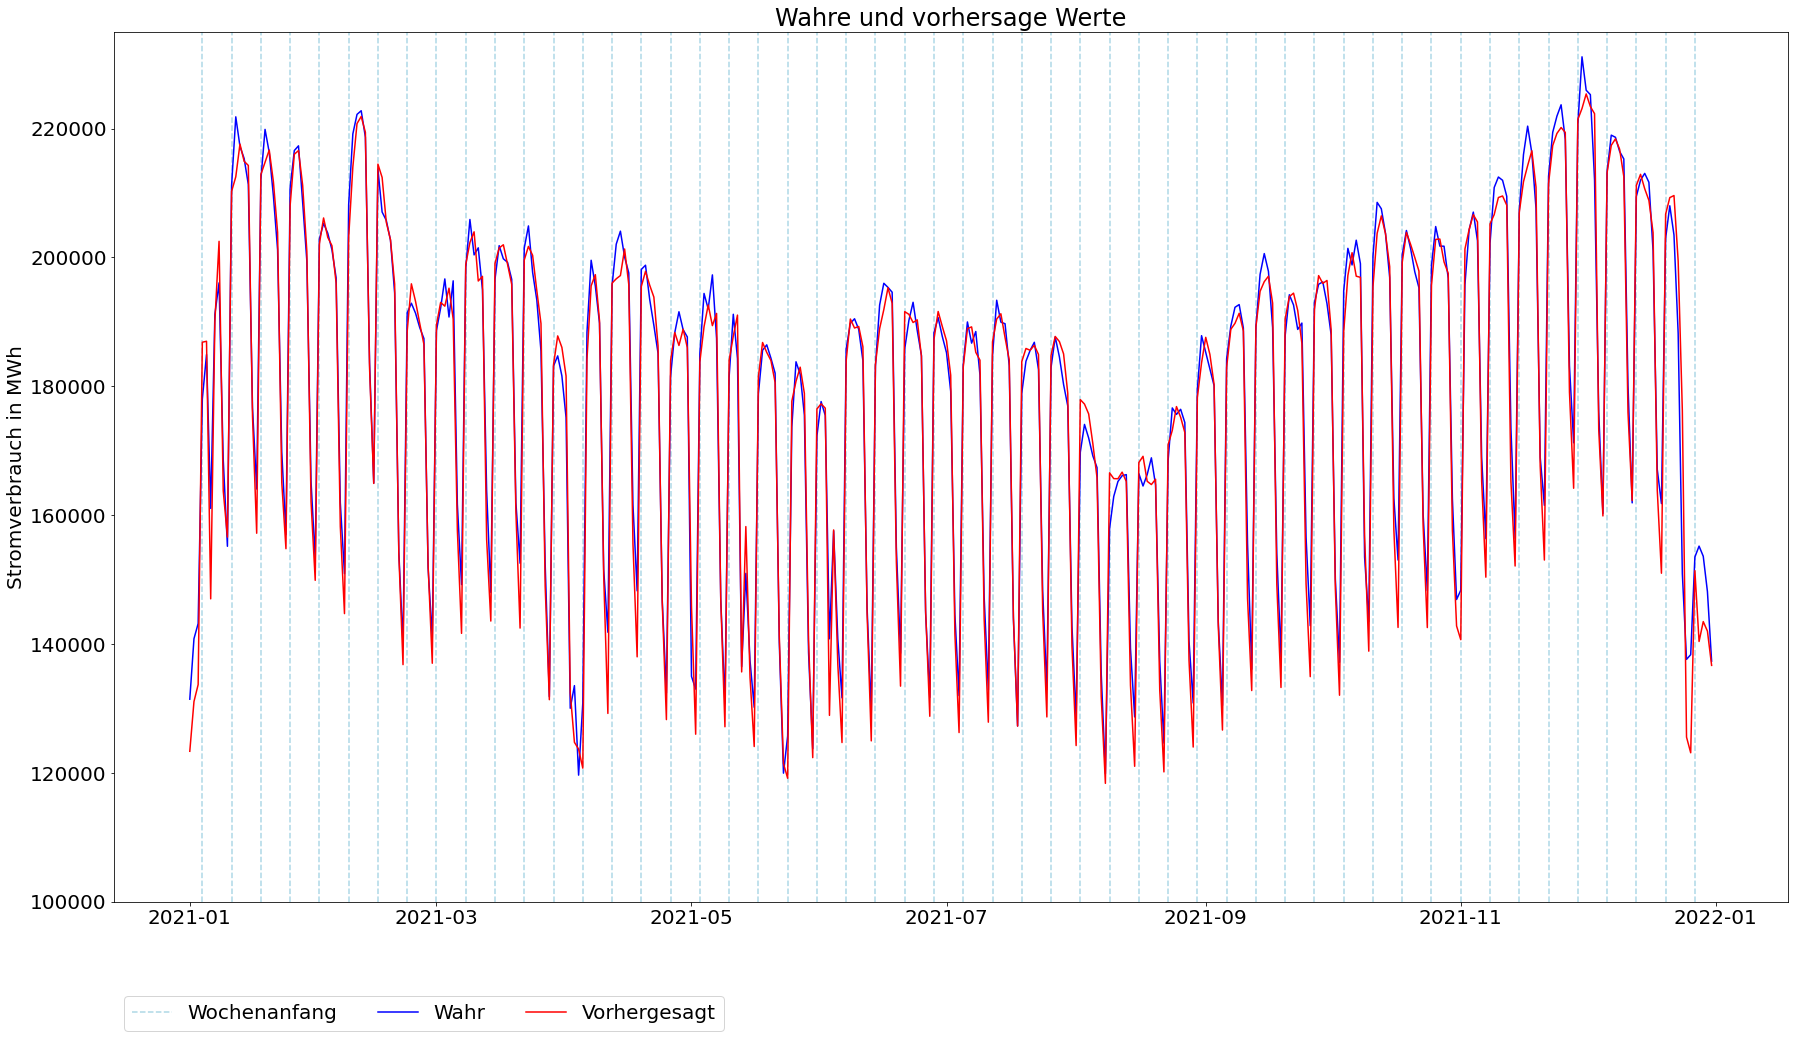

In [11]:
## Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

In [ ]:
model.save("Modelle/LSTM.h5"),

#from tensorflow.keras.models import load_model
#newmodel = load_model("Modelle/LSTM.h5", custom_objects={"root_mean_squared_error":root_mean_squared_error})
#newmodel.summary()